In [1]:
import pandas as pd
import numpy as np
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import scipy
from matplotlib.colors import ListedColormap
from functools import partial
from sklearn.model_selection import cross_val_score


In [2]:
df = pd.read_csv('wine.data', header=None, delimiter=',', dtype=float)
df = df.drop([2,3,4,5,6,8,9,10,11,12,13], axis=1)
df = df[df[0] != 3.0]
df[0] = df[0].replace({1.0: 1, 2.0: -1})
df[0] = df[0].astype(float)
X = df.iloc[:, 1:3].values  # Selects columns 2 and 3
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X) # THIS REALLY HELPED
Y = df.iloc[:, 0].values    # Selects column 1
Y = Y.reshape(-1, 1).astype(float)  
X_and_Y = np.hstack((X, Y))     # Stack them together for shuffling.
np.random.seed(1)               # Set the random seed.
np.random.shuffle(X_and_Y)      # Shuffle the data points in X_and_Y array

print(X.shape)
print(Y.shape)
print(X_and_Y[0])

(130, 2)
(130, 1)
[-0.81784764 -0.61230964 -1.        ]


In [3]:
def vis(X, Y, W=None, b=None):
    indices_neg1 = (Y == -1).nonzero()[0]
    indices_pos1 = (Y == 1).nonzero()[0]
    plt.scatter(X[:,0][indices_neg1], X[:,1][indices_neg1],
                c='blue', label='class -1')
    plt.scatter(X[:,0][indices_pos1], X[:,1][indices_pos1],
                c='red', label='class 1')
    plt.legend()
    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')

    if W is not None:
        # w0x0+w1x1+b=0 => x1=-w0x0/w1-b/w1
        w0 = W[0]
        w1 = W[1]
        temp = -w1*np.array([X[:,1].min(), X[:,1].max()])/w0-b/w0
        x0_min = max(temp.min(), X[:,0].min())
        x0_max = min(temp.max(), X[:,1].max())
        x0 = np.linspace(x0_min,x0_max,100)
        x1 = -w0*x0/w1-b/w1
        plt.plot(x0,x1,color='black')

    plt.show()

# SVM
# 20 training

In [7]:
# Divide the data points into training set and test set.
X_shuffled = X_and_Y[:,:2]
Y_shuffled = X_and_Y[:,2]

split_index = int(0.2 * len(X_shuffled))  

X_train = X_shuffled[:split_index]
Y_train = Y_shuffled[:split_index]
X_test = X_shuffled[split_index:]
Y_test = Y_shuffled[split_index:]   
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(26, 2)
(26,)
(104, 2)
(104,)


C = 0.1
Decision boundary: 0.778x0+0.251x1+-0.087=0
Training error: 0.038461538461538436
Cross-validation score: 0.920




C = 1
Decision boundary: 1.336x0+0.439x1+-0.212=0
Training error: 0.038461538461538436
Cross-validation score: 0.920




C = 10
Decision boundary: 3.245x0+1.410x1+-0.846=0
Training error: 0.0
Cross-validation score: 0.880




C = 100
Decision boundary: 7.100x0+3.558x1+-2.427=0
Training error: 0.0
Cross-validation score: 0.880




C = 1000
Decision boundary: 8.120x0+4.126x1+-2.847=0
Training error: 0.0
Cross-validation score: 0.920




Best parameter C* = 10
Decision boundary: 3.245x0+1.410x1+-0.846=0


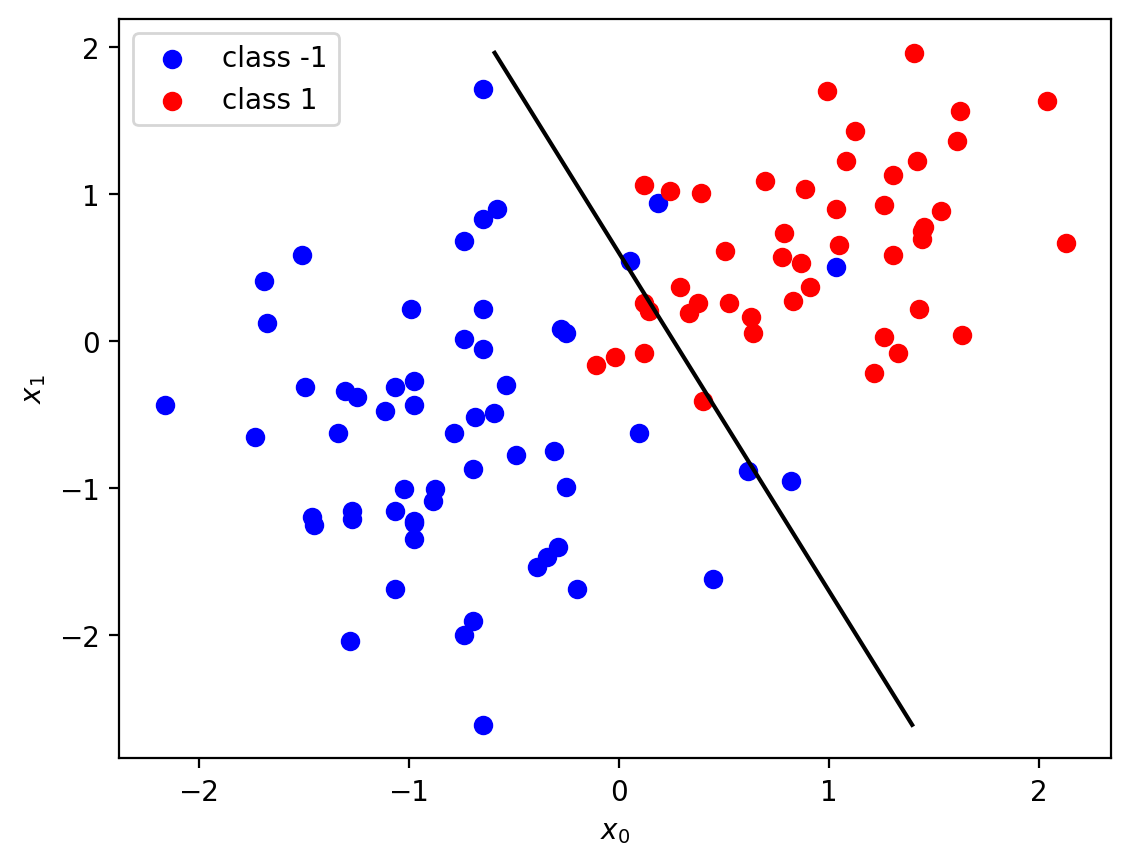

Test error: 0.09615384615384615
Train error: 0.0


In [8]:
from sklearn.model_selection import cross_val_score

# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, classifier):
    # Hint: Use classifier.predict()
    Y_pred = classifier.predict(X)

    # Hint: Use accuracy_score().
    e = 1 - accuracy_score(Y, Y_pred)
    return e

C_list = [0.1, 1, 10, 100, 1000]
opt_e_train = 1.0   # Optimal training error.
opt_classifier = None  # Optimal classifier.
opt_C = None  # Optimal C.

for C in C_list:
    # Create a linear SVM classifier.
    # Hints: You can use svm.LinearSVC()
    #        Besides, we use Hinge loss and L2 penalty for weights.
    #        The max iterations should be set to 100000.
    #        The regularization parameter should be set as C.
    #        The other arguments of svm.LinearSVC() are set as default values.
    classifier = svm.LinearSVC(C=C, max_iter=100000, penalty='l2', dual=False)

    # Use the classifier to fit the training set (use X_train, Y_train).
    # Hint: You can use classifier.fit().
    classifier.fit(X_train, Y_train)

    # Obtain the weights and bias from the linear SVM classifier.
    W = classifier.coef_[0]
    b = classifier.intercept_[0]

    # Calculate cross-validation score.
    cv_score = cross_val_score(classifier, X_train, Y_train, cv=5).mean()

    # Show decision boundary, training error and test error.
    print('C = {}'.format(C))
    print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(W[0], W[1], b))
    e_train = calc_error(X_train, Y_train, classifier)
    print('Training error: {}'.format(e_train))
    print('Cross-validation score: {:.3f}'.format(cv_score))
    print('\n\n\n')

    # Judge if it is the optimal one.
    if e_train < opt_e_train:
        opt_e_train = e_train
        opt_classifier = classifier
        opt_C = C

opt_W = opt_classifier.coef_[0]
opt_b = opt_classifier.intercept_[0]
print('Best parameter C* = {}'.format(opt_C))
print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(opt_W[0], opt_W[1], opt_b))
vis(X_test, Y_test, opt_W, opt_b)
print('Test error: {}'.format(calc_error(X_test, Y_test, opt_classifier)))
print('Train error: {}'.format(calc_error(X_train, Y_train, opt_classifier)))


# 50 training

In [9]:
# Divide the data points into training set and test set.
X_shuffled = X_and_Y[:,:2]
Y_shuffled = X_and_Y[:,2]

split_index = int(0.5 * len(X_shuffled))

X_train = X_shuffled[:split_index]
Y_train = Y_shuffled[:split_index]
X_test = X_shuffled[split_index:]
Y_test = Y_shuffled[split_index:]   
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(65, 2)
(65,)
(65, 2)
(65,)


C = 0.1
Decision boundary: 0.897x0+0.267x1+-0.120=0
Training error: 0.07692307692307687
Cross-validation score: 0.923




C = 1
Decision boundary: 1.250x0+0.350x1+-0.195=0
Training error: 0.07692307692307687
Cross-validation score: 0.877




C = 10
Decision boundary: 1.365x0+0.392x1+-0.216=0
Training error: 0.07692307692307687
Cross-validation score: 0.877




C = 100
Decision boundary: 1.381x0+0.398x1+-0.219=0
Training error: 0.07692307692307687
Cross-validation score: 0.877




C = 1000
Decision boundary: 1.382x0+0.398x1+-0.219=0
Training error: 0.07692307692307687
Cross-validation score: 0.877




Best parameter C* = 0.1
Decision boundary: 0.897x0+0.267x1+-0.120=0


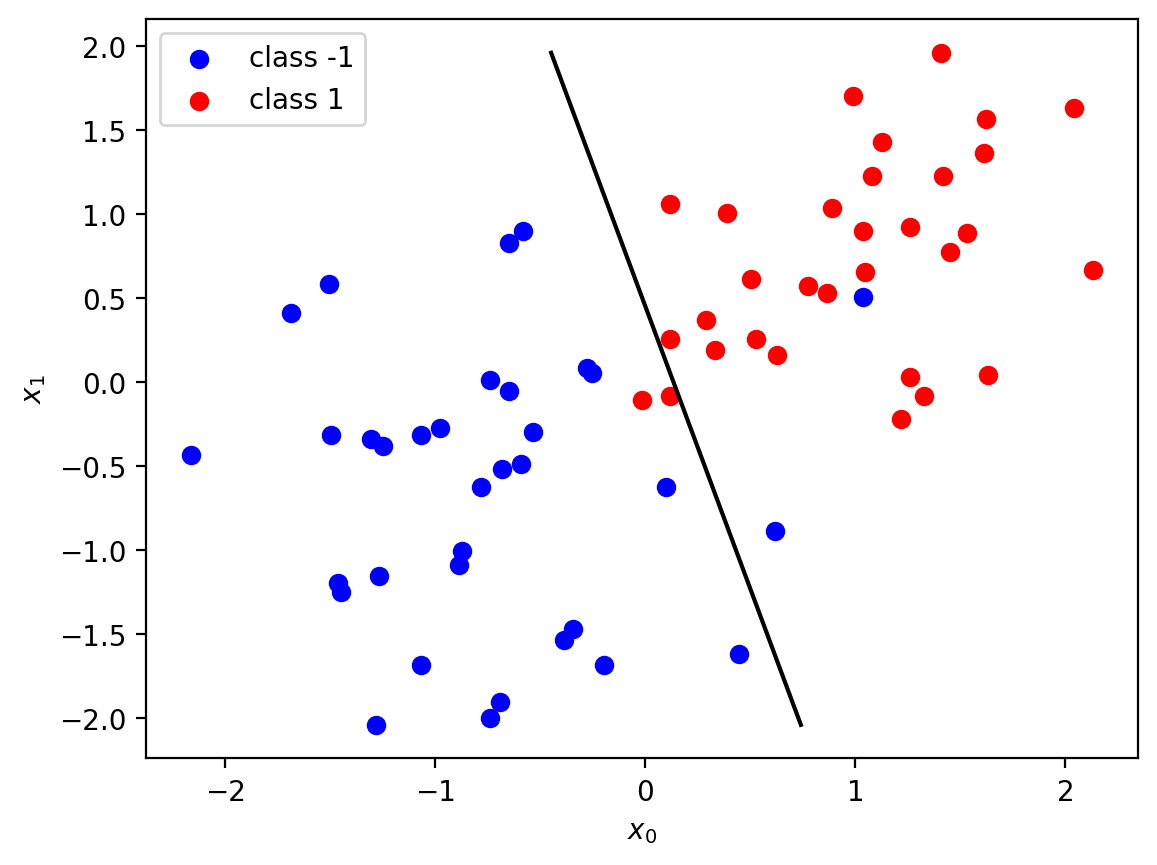

Test error: 0.06153846153846154
Train error: 0.07692307692307687


In [10]:
from sklearn.model_selection import cross_val_score

# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, classifier):
    # Hint: Use classifier.predict()
    Y_pred = classifier.predict(X)

    # Hint: Use accuracy_score().
    e = 1 - accuracy_score(Y, Y_pred)
    return e

C_list = [0.1, 1, 10, 100, 1000]
opt_e_train = 1.0   # Optimal training error.
opt_classifier = None  # Optimal classifier.
opt_C = None  # Optimal C.

for C in C_list:
    # Create a linear SVM classifier.
    # Hints: You can use svm.LinearSVC()
    #        Besides, we use Hinge loss and L2 penalty for weights.
    #        The max iterations should be set to 100000.
    #        The regularization parameter should be set as C.
    #        The other arguments of svm.LinearSVC() are set as default values.
    classifier = svm.LinearSVC(C=C, max_iter=100000, penalty='l2', dual=False)

    # Use the classifier to fit the training set (use X_train, Y_train).
    # Hint: You can use classifier.fit().
    classifier.fit(X_train, Y_train)

    # Obtain the weights and bias from the linear SVM classifier.
    W = classifier.coef_[0]
    b = classifier.intercept_[0]

    # Calculate cross-validation score.
    cv_score = cross_val_score(classifier, X_train, Y_train, cv=5).mean()

    # Show decision boundary, training error and test error.
    print('C = {}'.format(C))
    print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(W[0], W[1], b))
    e_train = calc_error(X_train, Y_train, classifier)
    print('Training error: {}'.format(e_train))
    print('Cross-validation score: {:.3f}'.format(cv_score))
    print('\n\n\n')

    # Judge if it is the optimal one.
    if e_train < opt_e_train:
        opt_e_train = e_train
        opt_classifier = classifier
        opt_C = C

opt_W = opt_classifier.coef_[0]
opt_b = opt_classifier.intercept_[0]
print('Best parameter C* = {}'.format(opt_C))
print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(opt_W[0], opt_W[1], opt_b))
vis(X_test, Y_test, opt_W, opt_b)
print('Test error: {}'.format(calc_error(X_test, Y_test, opt_classifier)))
print('Train error: {}'.format(calc_error(X_train, Y_train, opt_classifier)))


# 80 training

In [11]:
# Divide the data points into training set and test set.
X_shuffled = X_and_Y[:,:2]
Y_shuffled = X_and_Y[:,2]

split_index = int(0.8 * len(X_shuffled))

X_train = X_shuffled[:split_index]
Y_train = Y_shuffled[:split_index]
X_test = X_shuffled[split_index:]
Y_test = Y_shuffled[split_index:]   
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(104, 2)
(104,)
(26, 2)
(26,)


C = 0.1
Decision boundary: 1.010x0+0.318x1+-0.125=0
Training error: 0.05769230769230771
Cross-validation score: 0.943




C = 1
Decision boundary: 1.432x0+0.437x1+-0.184=0
Training error: 0.05769230769230771
Cross-validation score: 0.933




C = 10
Decision boundary: 1.615x0+0.511x1+-0.229=0
Training error: 0.05769230769230771
Cross-validation score: 0.924




C = 100
Decision boundary: 1.641x0+0.521x1+-0.236=0
Training error: 0.05769230769230771
Cross-validation score: 0.924




C = 1000
Decision boundary: 1.643x0+0.522x1+-0.237=0
Training error: 0.05769230769230771
Cross-validation score: 0.924




Best parameter C* = 0.1
Decision boundary: 1.010x0+0.318x1+-0.125=0


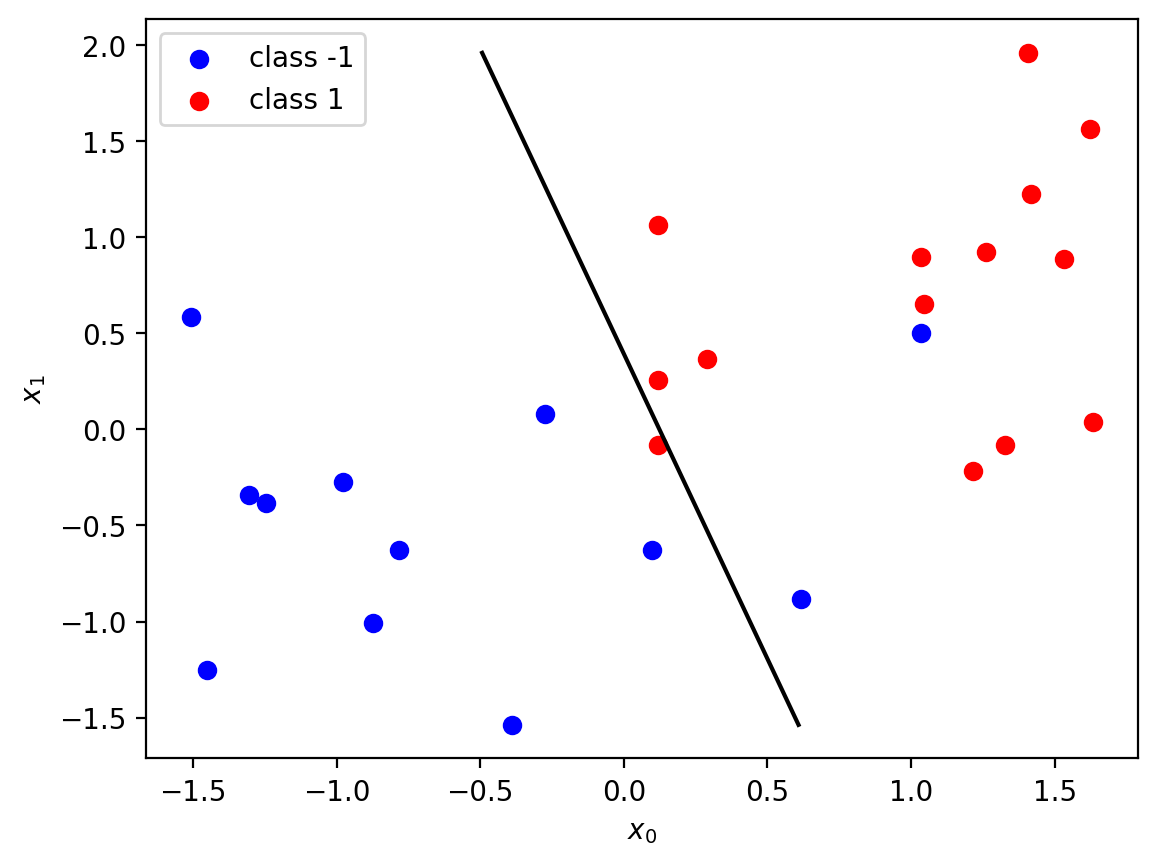

Test error: 0.11538461538461542
Train error: 0.05769230769230771


In [12]:
from sklearn.model_selection import cross_val_score

# Calculate error given feature vectors X and labels Y.
def calc_error(X, Y, classifier):
    # Hint: Use classifier.predict()
    Y_pred = classifier.predict(X)

    # Hint: Use accuracy_score().
    e = 1 - accuracy_score(Y, Y_pred)
    return e

C_list = [0.1, 1, 10, 100, 1000]
opt_e_train = 1.0   # Optimal training error.
opt_classifier = None  # Optimal classifier.
opt_C = None  # Optimal C.

for C in C_list:
    # Create a linear SVM classifier.
    # Hints: You can use svm.LinearSVC()
    #        Besides, we use Hinge loss and L2 penalty for weights.
    #        The max iterations should be set to 100000.
    #        The regularization parameter should be set as C.
    #        The other arguments of svm.LinearSVC() are set as default values.
    classifier = svm.LinearSVC(C=C, max_iter=100000, penalty='l2', dual=False)

    # Use the classifier to fit the training set (use X_train, Y_train).
    # Hint: You can use classifier.fit().
    classifier.fit(X_train, Y_train)

    # Obtain the weights and bias from the linear SVM classifier.
    W = classifier.coef_[0]
    b = classifier.intercept_[0]

    # Calculate cross-validation score.
    cv_score = cross_val_score(classifier, X_train, Y_train, cv=5).mean()

    # Show decision boundary, training error and test error.
    print('C = {}'.format(C))
    print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(W[0], W[1], b))
    e_train = calc_error(X_train, Y_train, classifier)
    print('Training error: {}'.format(e_train))
    print('Cross-validation score: {:.3f}'.format(cv_score))
    print('\n\n\n')

    # Judge if it is the optimal one.
    if e_train < opt_e_train:
        opt_e_train = e_train
        opt_classifier = classifier
        opt_C = C

opt_W = opt_classifier.coef_[0]
opt_b = opt_classifier.intercept_[0]
print('Best parameter C* = {}'.format(opt_C))
print('Decision boundary: {:.3f}x0+{:.3f}x1+{:.3f}=0'.format(opt_W[0], opt_W[1], opt_b))
vis(X_test, Y_test, opt_W, opt_b)
print('Test error: {}'.format(calc_error(X_test, Y_test, opt_classifier)))
print('Train error: {}'.format(calc_error(X_train, Y_train, opt_classifier)))
